# Stress Signal Classification with Convolutional Neural Networks

**Author:** [Mark Goertz](https://github.com/markgoertz)<br>
**Date created:** 2024/04/04<br>
**Last modified:** 2022/04/05<br>
**Description:** Training a Convolutional model to classify stress signals produced by exposure to certain stimuli.

## Setup and Data Downloads
First, lets install our dependencies:

In [2]:
%pip install os -q
%pip install pandas -q
%pip install matplotlib -q

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [10]:
MAIN_PATH = os.path.dirname(os.getcwd())
DATA_SUBPATH = '/data'
UNPROCESSED_PATH = MAIN_PATH + DATA_SUBPATH + '/unprocessed/WESAD'
PROCESSED_PATH = MAIN_PATH + DATA_SUBPATH + '/processed/WESAD'

This Python script is part of a data preprocessing pipeline, for a machine learning task. The script is designed to handle data from multiple folders and multiple files within each folder.

The `minfolder` and `maxfolder` variables define the range of folders to be processed. The `folders` list generates a list of folder names in the format 'S2', 'S3', ..., 'S17'. This assumes that the folders are named in this specific format of the `WESAD` dataset.

The `final_columns` dictionary defines the final column names for each type of data file (`'ACC'`, `'EDA'`, `'HR'`, `'TEMP'`). Each key-value pair in the dictionary corresponds to a specific type of data file and its associated columns.

The `names` dictionary defines the column names for each type of data file in the `raw data`. This is used to map the raw data columns to the final column names defined in final_columns.

The `desired_signals` list contains the names of the data files to be processed. This list is used to filter out any `unwanted data files` in the folders.

Finally, four empty pandas DataFrames (`acc`, `eda`, `hr`, `temp`) are created with the column names defined in `final_columns`. These DataFrames will be used to store the processed data from each type of data file.

The class declaration for range is a built-in Python class that represents an immutable sequence of numbers and is commonly used for looping a specific number of times in for loops. It's not directly used in the provided code, but it's used implicitly in the list comprehension when generating the folders list.

In [11]:
minfolder = 2
maxfolder = 18
folders = [f'S{i}' for i in range(minfolder, maxfolder)]
final_columns = {
    'ACC': ['id','X', 'Y', 'datetime'],
    'EDA': ['id','EDA','datetime'],
    'HR': ['id','HR','datetime'],
    'TEMP': ['id','TEMP','datetime']
}

names = {
    'ACC.csv': ['X', 'Y', 'Z'],
    'EDA.csv': ['EDA'],
    'HR.csv': ['HR'],
    'TEMP.csv': ['TEMP']
}

desired_signals = ['ACC.csv', 'EDA.csv', 'HR.csv', 'TEMP.csv']
acc = pd.DataFrame(columns=final_columns['ACC'])
eda = pd.DataFrame(columns=final_columns['EDA'])
hr = pd.DataFrame(columns=final_columns['HR'])
temp = pd.DataFrame(columns=final_columns['TEMP'])

The provided Python function `process_df(df, file)` is designed to process a DataFrame `df` and a file name `file`. The function performs several operations to transform the input DataFrame and returns the processed DataFrame.

First, it extracts the `start_timestamp` and `sample_rate` from the first and second rows of the DataFrame, respectively. The `start_timestamp` is to be the first value in the DataFrame, and the `sample_rate` is the first value in the second row. These values are accessed using the iloc indexer of the DataFrame, which allows selection by position.

Next, it creates a new DataFrame called: `new_df` from the input DataFrame, skipping the first two rows. This is done by slicing the DataFrame with `df.iloc[2:]` to exclude the first two rows, and then creating a new DataFrame with the same column names as the original DataFrame.

The function then adds two new columns to `new_df`: 'id' and 'datetime'. The 'id' column is created by extracting the last two characters from the file name. The 'datetime' column is created by adding a time delta to the start_timestamp for each row in the DataFrame. The time delta is calculated as the row index divided by the sample_rate, which assumes that the data is sampled at regular intervals.

In [12]:
def process_df(df, file):
    # Get the start timestamp and sample rate
    start_timestamp = df.iloc[0, 0]
    sample_rate = df.iloc[1, 0]

    # Convert the Unix timestamp to a datetime object
    unix_timestamp = int(float((start_timestamp)))
    utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
    
    # Format the datetime object as a string
    formatted_time = utc_datetime.strftime('%Y-%m-%d %H:%M:%S UTC')
    print('Initial time', formatted_time)

    # Sample rate
    sample_rate = int(float(sample_rate))
    print('Sample rate',sample_rate,'Hz')

    # Interval in milliseconds (as string)
    interval_ms = str(1000/sample_rate) + 'ms'
    print('Interval',interval_ms)

    new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)  # skip first two rows
    new_df['id'] = file[-3:]
    new_df['datetime'] = [(start_timestamp + i/sample_rate) for i in range(len(new_df))]
    
    nr_rows, nr_columns = new_df.shape
    new_df['Time'] = pd.date_range(start=utc_datetime, periods=nr_rows, freq=interval_ms)

    
    if sample_rate > 4:
        ds_factor = int(sample_rate / 4)
        new_df = new_df.iloc[::ds_factor, :]
    return new_df    

## Read data from `unprocessed folder`

We use the Pandas library to read the `unprocessed folder` to extract each measurement such as: `ACC`, `EDA`, `HR`, `TEMP` and process it to `processed` folder to use it in a later analysis.


In [13]:
for folder in folders:
    print(f"Currently processing folder: {folder}")
    folder_path = os.path.join(UNPROCESSED_PATH, folder)
    for signal in desired_signals:
        signal_path = os.path.join(folder_path, signal)
        if os.path.isfile(signal_path):
            df = pd.read_csv(signal_path, names=names[signal], header=None)
            if not df.empty:
                if signal == 'ACC.csv':
                    acc = pd.concat([acc, process_df(df, folder)])
                elif signal == 'EDA.csv':
                    eda = pd.concat([eda, process_df(df, folder)])
                elif signal == 'HR.csv':
                    hr = pd.concat([hr, process_df(df, folder)])
                elif signal == 'TEMP.csv':
                    temp = pd.concat([temp, process_df(df, folder)])

Currently processing folder: S2
Initial time 2017-05-22 07:15:25 UTC
Sample rate 32 Hz
Interval 31.25ms
Initial time 2017-05-22 07:15:25 UTC
Sample rate 4 Hz
Interval 250.0ms
Initial time 2017-05-22 07:15:35 UTC
Sample rate 1 Hz
Interval 1000.0ms
Initial time 2017-05-22 07:15:25 UTC
Sample rate 4 Hz
Interval 250.0ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\278731602.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  acc = pd.concat([acc, process_df(df, folder)])
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represen

Currently processing folder: S3
Initial time 2017-05-24 11:08:48 UTC
Sample rate 32 Hz
Interval 31.25ms
Initial time 2017-05-24 11:08:48 UTC
Sample rate 4 Hz
Interval 250.0ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

Initial time 2017-05-24 11:08:58 UTC
Sample rate 1 Hz
Interval 1000.0ms
Initial time 2017-05-24 11:08:48 UTC
Sample rate 4 Hz
Interval 250.0ms
Currently processing folder: S4
Initial time 2017-06-13 08:33:40 UTC
Sample rate 32 Hz
Interval 31.25ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

Initial time 2017-06-13 08:33:40 UTC
Sample rate 4 Hz
Interval 250.0ms
Initial time 2017-06-13 08:33:50 UTC
Sample rate 1 Hz
Interval 1000.0ms
Initial time 2017-06-13 08:33:40 UTC
Sample rate 4 Hz
Interval 250.0ms
Currently processing folder: S5
Initial time 2017-06-13 12:22:13 UTC
Sample rate 32 Hz
Interval 31.25ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

Initial time 2017-06-13 12:22:13 UTC
Sample rate 4 Hz
Interval 250.0ms
Initial time 2017-06-13 12:22:23 UTC
Sample rate 1 Hz
Interval 1000.0ms
Initial time 2017-06-13 12:22:13 UTC
Sample rate 4 Hz
Interval 250.0ms
Currently processing folder: S6


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

Initial time 2017-06-14 11:20:38 UTC
Sample rate 32 Hz
Interval 31.25ms
Initial time 2017-06-14 11:20:38 UTC
Sample rate 4 Hz
Interval 250.0ms
Initial time 2017-06-14 11:20:48 UTC
Sample rate 1 Hz
Interval 1000.0ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

Initial time 2017-06-14 11:20:38 UTC
Sample rate 4 Hz
Interval 250.0ms
Currently processing folder: S7
Initial time 2017-07-06 11:11:04 UTC
Sample rate 32 Hz
Interval 31.25ms
Initial time 2017-07-06 11:11:04 UTC
Sample rate 4 Hz
Interval 250.0ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

Initial time 2017-07-06 11:11:14 UTC
Sample rate 1 Hz
Interval 1000.0ms
Initial time 2017-07-06 11:11:04 UTC
Sample rate 4 Hz
Interval 250.0ms
Currently processing folder: S8
Initial time 2017-07-10 11:10:40 UTC
Sample rate 32 Hz
Interval 31.25ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

Initial time 2017-07-10 11:10:40 UTC
Sample rate 4 Hz
Interval 250.0ms
Initial time 2017-07-10 11:10:50 UTC
Sample rate 1 Hz
Interval 1000.0ms
Initial time 2017-07-10 11:10:40 UTC
Sample rate 4 Hz
Interval 250.0ms
Currently processing folder: S9
Initial time 2017-07-11 11:10:41 UTC
Sample rate 32 Hz
Interval 31.25ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

Initial time 2017-07-11 11:10:41 UTC
Sample rate 4 Hz
Interval 250.0ms
Initial time 2017-07-11 11:10:51 UTC
Sample rate 1 Hz
Interval 1000.0ms
Initial time 2017-07-11 11:10:41 UTC
Sample rate 4 Hz
Interval 250.0ms
Currently processing folder: S10
Initial time 2017-07-25 07:05:08 UTC
Sample rate 32 Hz
Interval 31.25ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

Initial time 2017-07-25 07:05:08 UTC
Sample rate 4 Hz
Interval 250.0ms
Initial time 2017-07-25 07:05:18 UTC
Sample rate 1 Hz
Interval 1000.0ms
Initial time 2017-07-25 07:05:08 UTC
Sample rate 4 Hz
Interval 250.0ms
Currently processing folder: S11
Initial time 2017-07-25 11:14:19 UTC
Sample rate 32 Hz
Interval 31.25ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

Initial time 2017-07-25 11:14:19 UTC
Sample rate 4 Hz
Interval 250.0ms
Initial time 2017-07-25 11:14:29 UTC
Sample rate 1 Hz
Interval 1000.0ms
Initial time 2017-07-25 11:14:19 UTC
Sample rate 4 Hz
Interval 250.0ms
Currently processing folder: S12
Currently processing folder: S13
Initial time 2017-08-08 11:13:07 UTC
Sample rate 32 Hz
Interval 31.25ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

Initial time 2017-08-08 11:13:07 UTC
Sample rate 4 Hz
Interval 250.0ms
Initial time 2017-08-08 11:13:17 UTC
Sample rate 1 Hz
Interval 1000.0ms
Initial time 2017-08-08 11:13:07 UTC
Sample rate 4 Hz
Interval 250.0ms
Currently processing folder: S14
Initial time 2017-08-09 07:09:31 UTC
Sample rate 32 Hz
Interval 31.25ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

Initial time 2017-08-09 07:09:31 UTC
Sample rate 4 Hz
Interval 250.0ms
Initial time 2017-08-09 07:09:41 UTC
Sample rate 1 Hz
Interval 1000.0ms
Initial time 2017-08-09 07:09:31 UTC
Sample rate 4 Hz
Interval 250.0ms
Currently processing folder: S15
Initial time 2017-08-10 07:10:56 UTC
Sample rate 32 Hz
Interval 31.25ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

Initial time 2017-08-10 07:10:56 UTC
Sample rate 4 Hz
Interval 250.0ms
Initial time 2017-08-10 07:11:06 UTC
Sample rate 1 Hz
Interval 1000.0ms
Initial time 2017-08-10 07:10:56 UTC
Sample rate 4 Hz
Interval 250.0ms
Currently processing folder: S16
Initial time 2017-08-10 11:59:25 UTC
Sample rate 32 Hz
Interval 31.25ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

Initial time 2017-08-10 11:59:25 UTC
Sample rate 4 Hz
Interval 250.0ms
Initial time 2017-08-10 11:59:35 UTC
Sample rate 1 Hz
Interval 1000.0ms
Initial time 2017-08-10 11:59:25 UTC
Sample rate 4 Hz
Interval 250.0ms
Currently processing folder: S17
Initial time 2017-08-11 07:19:22 UTC
Sample rate 32 Hz
Interval 31.25ms
Initial time 2017-08-11 07:19:22 UTC
Sample rate 4 Hz
Interval 250.0ms
Initial time 2017-08-11 07:19:32 UTC
Sample rate 1 Hz
Interval 1000.0ms
Initial time 2017-08-11 07:19:22 UTC
Sample rate 4 Hz
Interval 250.0ms


C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_datetime = datetime.datetime.utcfromtimestamp(unix_timestamp)
C:\Users\goert\AppData\Local\Temp\ipykernel_21576\446856757.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.from

In [14]:
dataframes = [acc, hr, temp, eda]
filenames = ['combined_acc.csv', 'combined_hr.csv', 'combined_temp.csv', 'combined_eda.csv']

# Create the directory if it doesn't exist
os.makedirs(PROCESSED_PATH, exist_ok=True)

for df, filename in zip(dataframes, filenames):
    print(f"Saving {filename}...")
    df.to_csv(os.path.join(PROCESSED_PATH, filename), index=False)

Saving combined_acc.csv...


Saving combined_hr.csv...
Saving combined_temp.csv...
Saving combined_eda.csv...


In [23]:
df_s2 = df[df['id'] == 'S2'][['Time', 'EDA']]
df_s2.head()

,Time,EDA
0,2017-05-22 07:15:25.000,0.000000
1,2017-05-22 07:15:25.250,0.328021
2,2017-05-22 07:15:25.500,0.410026
3,2017-05-22 07:15:25.750,0.433090
4,2017-05-22 07:15:26.000,0.444622


## Visualize one sample from the data

Checking if the file exists and visual one sample of the data

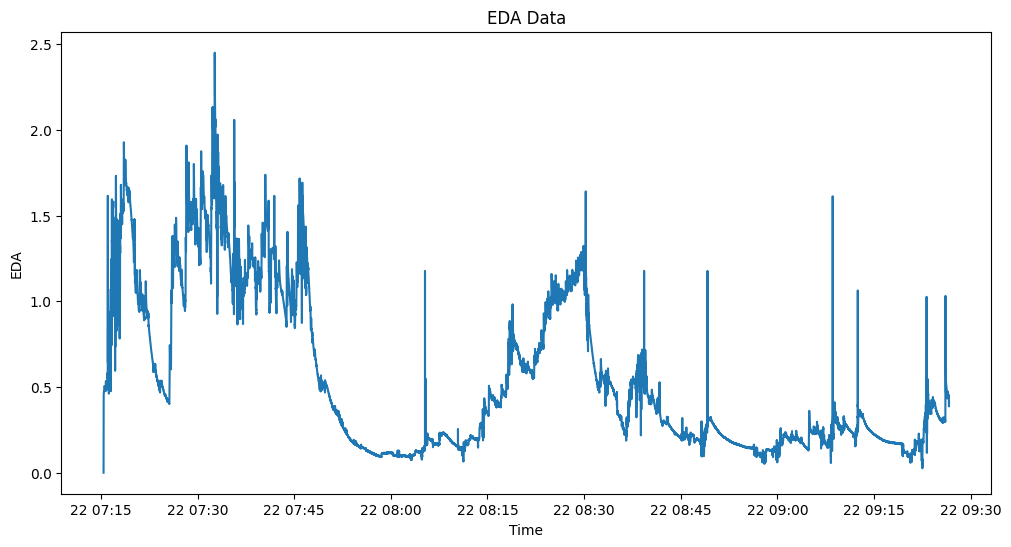

In [24]:
import matplotlib.pyplot as plt

# Plotting the EDA data
plt.figure(figsize=(12, 6))
plt.plot(df_s2['Time'], df_s2['EDA'])
plt.xlabel('Time')
plt.ylabel('EDA')
plt.title('EDA Data')
plt.show()

